classification with larger models.

We compare predictive performance on drug, drug-dose, and drug class prediction for the following three featurizations:
1. Summary statistics (i.e. usage frequency, i.e. Wiltschko et al)
2. Latent Dirichet Allocation (LDA) model (topic usage weights)
3. Dynamic Topic Decomposition (DTD) model (session factor weights)

These featurizations were referred to as "fingerprints" in the Wiltschko et al. manuscript.

In [1]:
from collections import OrderedDict

from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as onp

from tqdm.notebook import tqdm, trange

from scipy.cluster.hierarchy import fcluster, ward
from scipy.spatial.distance import pdist, squareform

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer

import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet  as cc  # used for maximally distinct categorical colors

from dtd.data import load_wiltschko22_data
from dtd.model3d import DirichletTuckerDecomp
from dtd.viz import draw_drug_class_boxes, set_syllable_cluster_ticks, set_time_within_session_ticks

## Get featurizations

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

# Load the binned syllable usage data and sum across bins.
# This is equivalent to loading the raw syllable sequences and summing across the full session.
filepath = DATASET_DIR + "syllable_binned_1min.npz"
X, batch_axes, event_axes, metadata = load_wiltschko22_data(filepath)

In [3]:
# Format labels for annotating plots later
syllable_cluster_names = metadata['syllable']['cluster_names']
frames_per_bin = metadata['frames_per_bin']
frames_per_sec = metadata['frames_per_sec']

# Modify long-form session drug class to print over two lines, for readability
session_drug_class_twoline = [
    name if name[:4] != 'anti' else 'anti-\n' + name[4:]
    for name in list(metadata['session']['drug_class'])
]

# Combine drug-dose labels
drug_dose_labels = [
    f'{drug}-{dose}' for drug, dose in zip(metadata['session']['drug_names'], metadata['session']['drug_doses'])
]

In [4]:
features = OrderedDict()

### Summary statistics

This featurization is simply the empirical frequency of syllable usage per session.
Let $x_{ntv} \in \mathbb{N}$ be the number of instances that syllable $v$ was expressed in session $n$ and time bin $t$. Then,
$$
\mathbf{z}_{n}^{\textrm{sum}} = \frac{\sum_t x_{nt\cdot}}{\sum_{tv} x_{ntv}} \in \Delta_V
$$

This is the simplest featurization and the one that was used in Wiltschko et al.

In [5]:
features['summary'] = X.sum(axis=1) / (X.sum(axis=1)).sum(axis=-1, keepdims=True)
print(f"{features['summary'].shape=}")  # (n_sessions, n_syllables)

features['summary'].shape=(500, 90)


### Latent Dirichlet Allocation model
We can also fit a latent Dirichlet allocation (LDA) model to the summarized data.
\begin{align*}
\textrm{for topics k=1,..., K}: & \\
\mathbf{\theta_k} &\sim \textrm{Dir}(\mathbf{\alpha}^\theta) \\
\textrm{for sessions n=1,..., N}: & \\
\mathbf{w_n} &\sim \textrm{Dir}(\mathbf{\alpha}^w) \\
\sum_t x_{nt} &\sim \textrm{Mult}(\sum_k \mathbf{w_n} \mathbf{\theta}_{k\cdot})
\end{align*}

We use the session weights, $\mathbf{w}_n \in \Delta_K$, as our featurizations.

In [6]:
# Manual model selection:
# - When fit with 30 topics, only 8 topics were non-uniform
# - When 8 topics fit, only 4 were non-uniform
lda = LDA(n_components=6)
lda_weights = lda.fit_transform(features['summary'])
print(f"{lda_weights.shape=}")

features['lda'] = lda_weights
lda_topics = lda.components_ / lda.components_.sum(axis=1, keepdims=True)

lda_weights.shape=(500, 6)


vmax=np.float64(0.5823770273953286)


Text(0.5, 1.0, 'lda topic weights')

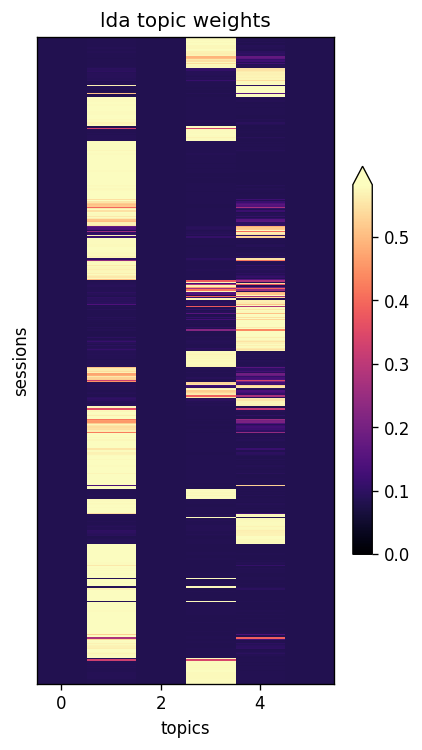

In [7]:
plt.figure(figsize=(4,7), dpi=120)

vmax = onp.percentile(lda_weights, 99)
print(f"{vmax=}")

ax = plt.gca()
im = ax.imshow(lda_weights, cmap='magma', clim=(0,vmax), interpolation='none', aspect='auto',)
plt.colorbar(im, extend='max', shrink=0.6)
ax.set_yticks([])
ax.set_ylabel('sessions')
ax.set_xlabel('topics')
ax.set_title("lda topic weights")

Text(0.5, 1.0, 'lda topic weights')

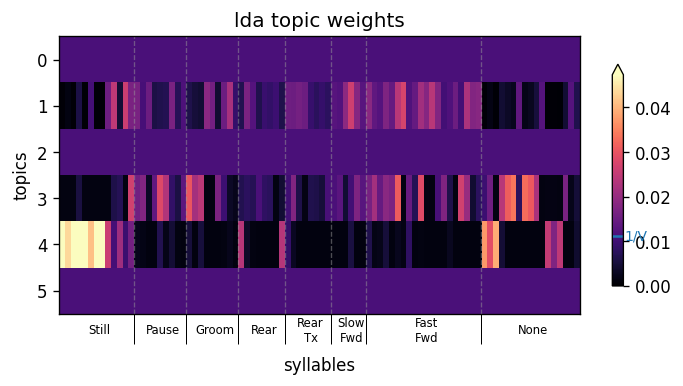

In [8]:
plt.figure(figsize=(7,3), dpi=120)

ax = plt.gca()
vmax = onp.percentile(lda_topics, 99)
im = ax.imshow(lda_topics, cmap='magma', clim=(0,vmax), interpolation='none', aspect='auto',)
cbar = plt.colorbar(im, extend='max', shrink=0.8)
n_syllables = 90

# Indicate "uniform" probability
cbar.ax.axhline(1/n_syllables, c='C0')
cbar.ax.text(
    1.05, 1/n_syllables, '1/V', transform=cbar.ax.get_yaxis_transform(),
    color='C0', va='center', fontsize='small',
)

ax.set_ylabel('topics')
ax.set_xlabel('syllables')

set_syllable_cluster_ticks(syllable_cluster_names, axis='x',)

ax.set_title("lda topic weights")

### DTD model

Finally, we also fit a DTD model, where

\begin{align*}
\mathbf{\theta}_k &\sim \textrm{Dir}(\mathbf{\alpha}^\theta) && \textrm{for topics k=1,..., K}\\
\mathbf{\psi}_t &\sim \textrm{Dir}(\mathbf{\alpha}^\psi) && \textrm{for bin t=1,..., T}\\
\mathbf{\phi}_n &\sim \textrm{Dir}(\mathbf{\alpha}^\phi) && \textrm{for sessions n=1,..., N}\\
\textrm{for sessions n=1,..., N } & \textrm{and bins t=1,..., T}:\\
\mathbf{x}_{nt} &\sim \sum \textrm{Mult}(\sum_{ijk} g_{ijk}\phi_{ni} \psi_{tj} \theta_k)
\end{align*}

We use the session factors, $\mathbf{\psi}_n \in \Delta_I$, as our featurizations. These session factors are a further factorization of the LDA session weights,
$$
\mathbf{w}_n \approx \sum_t \sum_{ij} g_{ij} \psi_{ni} \phi_{tj}
$$

**Parsimonious model**

In [5]:
# import os
# os.environ['JAX_PLATFORMS'] = "cpu"  # set this flag if running into GPU discovery issues
# 30-40 s per initialization on cpu
# 23s for all 10 inits on gpu

def fit_dtd(key, X, k1, k2, k3, n_inits=10, n_iters=500):
    """Fit DTD model with n random initializations; return model with best log prob."""
    d1, d2, d3 = X.shape
    event_axes = (2,)
    batch_shape = (d1,d2)

    total_counts = int(X.sum(event_axes).ravel()[0])
    dummy_mask = jnp.ones(batch_shape, dtype=bool)  # batch_ndims=2
    model = DirichletTuckerDecomp(total_counts, k1, k2, k3, alpha=1.1)

    def _fit(key, ):
        # Initialize
        init_params = model.sample_params(key, d1, d2, d3, conc=0.5)

        # Fit model to held-in data
        params, lps = model.fit(X, dummy_mask, init_params, n_iters)

        return params, lps[-1]

    all_params, all_lps = vmap(_fit)(jr.split(key, n_inits))

    # Use the param with the best log prob
    i_best = jnp.argmax(all_lps)
    params = tuple([param[i_best] for param in all_params])

    return params


In [ ]:
key = jr.key(1230)
k1, k2, k3 = 20, 4, 30  # these is the model size suggested by cross-validation
n_iters = 500
n_inits = 10
dtd_params_min = fit_dtd(key, X, k1, k2, k3, n_inits=10, n_iters=500)

features['dtd_20_4_30'] = dtd_params_min[1]

**Visualize session factors**

assgn.shape=(20,)
[10  4  4 12 13 14  9  5 10  1  5  6 11  7  8  2  8  9  1  3]


Text(0.5, 1.0, 'session factor weights, k1=20')

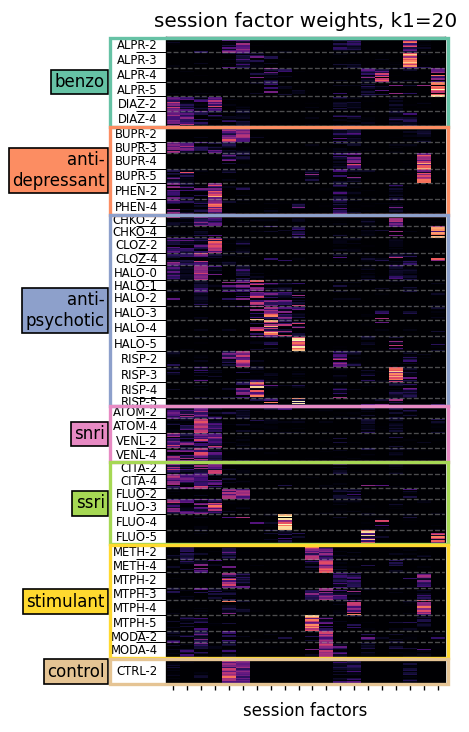

In [11]:
session_factors = dtd_params_min[1]

# ------------------------------------------------------------------------------------------------
# Cluster session factors for visualizations
z = ward(pdist(session_factors.T))

# t (float): Threshold of "inconsistency" statistic for forming flat clusters
# increase to form fewer clusters, decrease to from more clusters
assgn = fcluster(z, t=0.3)
print(f"{assgn.shape=}")
print(assgn)

perm = onp.argsort(assgn)

# ------------------------------------------------------------------------------------------------
d, k = session_factors.shape

plt.figure(figsize=(3,7), dpi=120)
ax = plt.gca()

ax.imshow(session_factors[:,perm], cmap='magma', clim=(0,1), interpolation='none', aspect='auto',)

# Label axes
ax.set_xticks(range(session_factors.shape[-1]))
ax.set_xticklabels([])
ax.set_xlabel('session factors')

set_syllable_cluster_ticks(drug_dose_labels, axis='y')
draw_drug_class_boxes(session_drug_class_twoline, bbox_x=-0.2, bbox_w=1.21, ax=ax)

ax.set_title(f'session factor weights, k1={k}', fontsize='large')

**Visualize dynamic topics**

The dynamic topics are the combined factors that each session weight, $\phi_{ni}$ acts upon, i.e.

Recall that expected probability of every bin of observations is convex combination of the corresponding factors:
$$
\pi_{nt} = \sum_{ijk} g_{ijk} \psi_{ni} \phi_{tj} \mathbf{\theta}_{k\cdot} \in \Delta_V
$$
We define dynamic topics as the components that are loaded by the session weights, $\psi_{ni}$ for $i=1,\ldots, K_1$:
$$
\mathbf{u}_i = \sum_{jk} g_{ijk} \mathbf{\phi}_{\cdot j} \mathbf{\theta}_{k\cdot} \in \{\Delta_V\}^T
$$
such that
$$
\pi_{nt} = \sum_{i} \psi_{ni} \mathbf{u}_{i t \cdot}
$$

$$\mathbf{\psi}_{\cdot, i}$$

Text(0, 0.5, 'syllable ids')

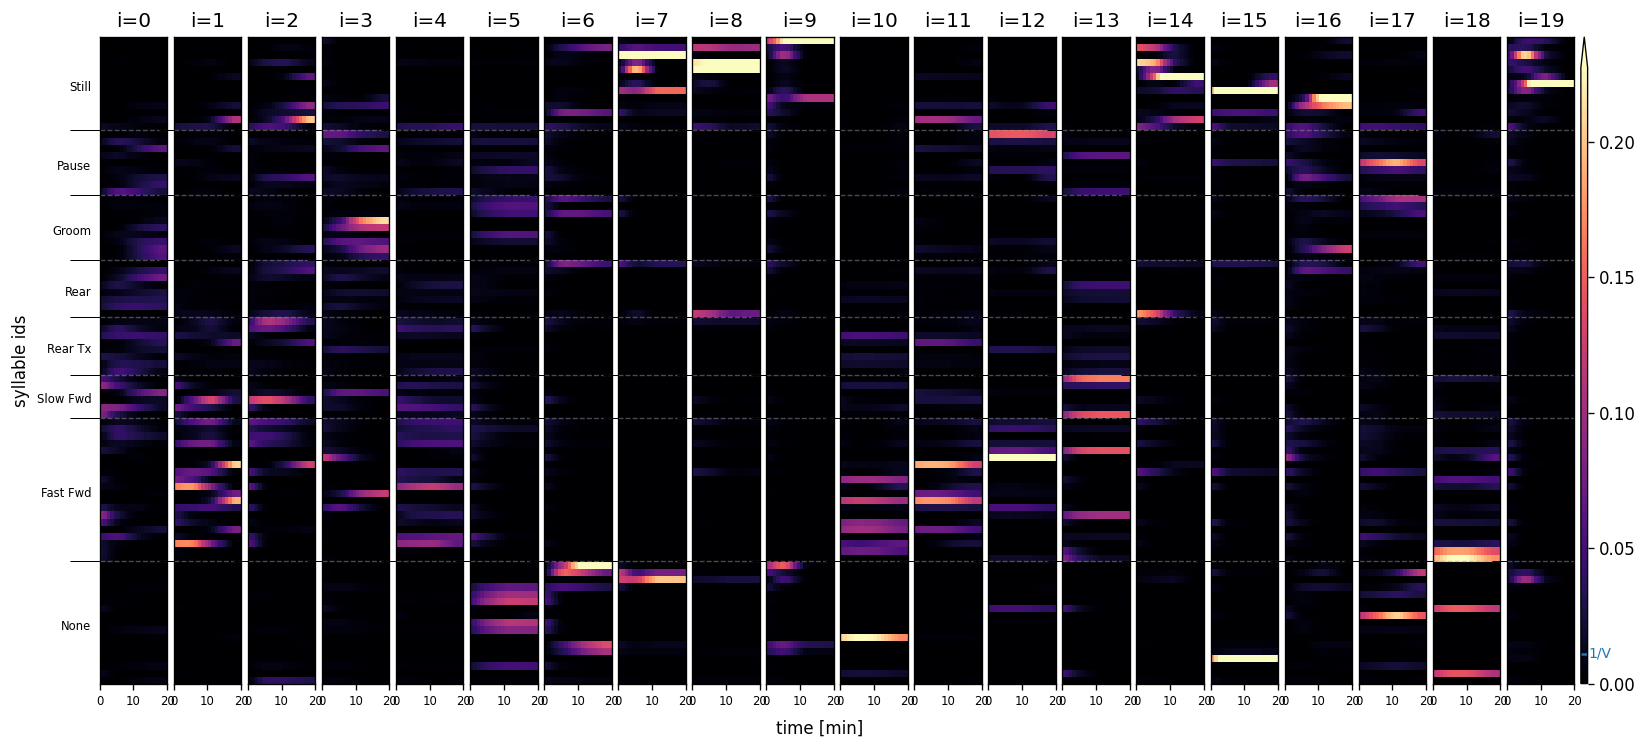

In [12]:
g, f1, f2, f3 = dtd_params_min

dynamic_topics = jnp.einsum("ijk,tj,kv->itv", g, f2, f3)
# vmax = dynamic_topics.max()
vmax = onp.percentile(dynamic_topics, 99.5)
k1, d2, d3 = dynamic_topics.shape

fig = plt.figure(figsize=(16,7), dpi=120)

axs = fig.subplots(
    ncols=k1+1,  # add 1 for cax
    width_ratios=(1,)*k1 + (0.1,),
    gridspec_kw=dict(wspace=0.1),
)
axs, cax = axs[:-1], axs[-1]

for i, ax in enumerate(axs):
    im = ax.imshow(
        dynamic_topics[perm[i]].T,  # don't forget to perm !
        cmap='magma', clim=(0,vmax),
        interpolation='none', aspect='auto',
    )

    # Set within-session time ticks
    set_time_within_session_ticks(
        d2, frames_per_bin, frames_per_sec, tick_period=10, ax=ax
    )

    # Remove syllable axis ticks
    ax.set_yticks([])
    set_syllable_cluster_ticks(
        syllable_cluster_names,
        label=(True if i==0 else False),
        ax=ax, axis='y',
    )

    ax.set_title(f"i={i}")

cbar = plt.colorbar(im, cax=cax, extend='max')

# Indicate "uniform" probability
n_syllables = 90
cbar.ax.axhline(1/n_syllables, c='C0')
cbar.ax.text(
    1.05, 1/n_syllables, '1/V', transform=cbar.ax.get_yaxis_transform(),
    color='C0', va='center', fontsize='small',
)

plt.annotate(
    f"time [min]", (0.5, 0.05), xycoords=fig.transFigure, ha='center'
)
axs[0].set_ylabel('syllable ids')


**Bigger model**

In [13]:
key = jr.key(320)
k1, k2, k3 = 40, 8, 50

dtd_params_big = fit_dtd(key, X, k1, k2, k3, n_inits=10, n_iters=500)
features['dtd_40_8_50'] = dtd_params_big[1]

  0%|          | 0/500 [00:00<?, ?it/s]

**Visualize session factor weights**

assgn.shape=(40,)
[11  3  1 17  1  8 12  5  8 24 10 20 16 20 11  6  7 26 25 14 15  2 21  9
 22 13 18 10  4 12  3 19 25  6 18 17 23 27 15 14]


Text(0.5, 1.0, 'session factor weights, k1=40')

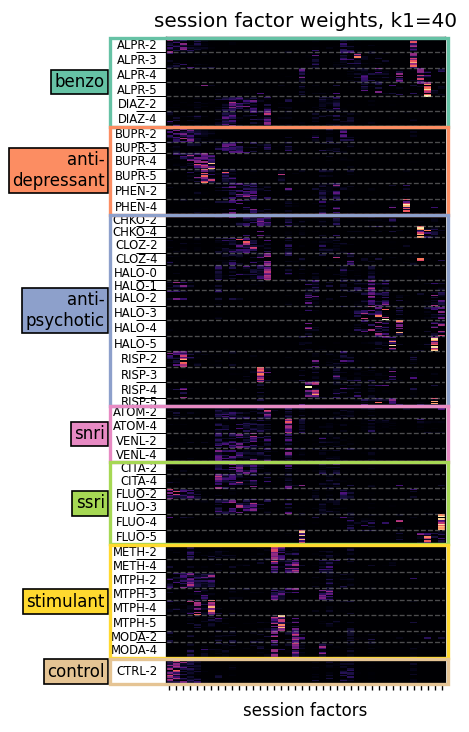

In [14]:
session_factors = dtd_params_big[1]

# ------------------------------------------------------------------------------------------------
# Cluster session factors for visualizations
z = ward(pdist(session_factors.T))

# t (float): Threshold of "inconsistency" statistic for forming flat clusters
# increase to form fewer clusters, decrease to from more clusters
assgn = fcluster(z, t=0.3)
print(f"{assgn.shape=}")
print(assgn)

perm = onp.argsort(assgn)

# ------------------------------------------------------------------------------------------------
d, k = session_factors.shape

plt.figure(figsize=(3,7), dpi=120)
ax = plt.gca()

ax.imshow(session_factors[:,perm], cmap='magma', clim=(0,1), interpolation='none', aspect='auto',)

# Label axes
ax.set_xticks(range(session_factors.shape[-1]))
ax.set_xticklabels([])
ax.set_xlabel('session factors')

set_syllable_cluster_ticks(drug_dose_labels, axis='y')
draw_drug_class_boxes(session_drug_class_twoline, bbox_x=-0.2, bbox_w=1.21, ax=ax)

ax.set_title(f'session factor weights, k1={k}', fontsize='large')

**Visualize dynamic topics**

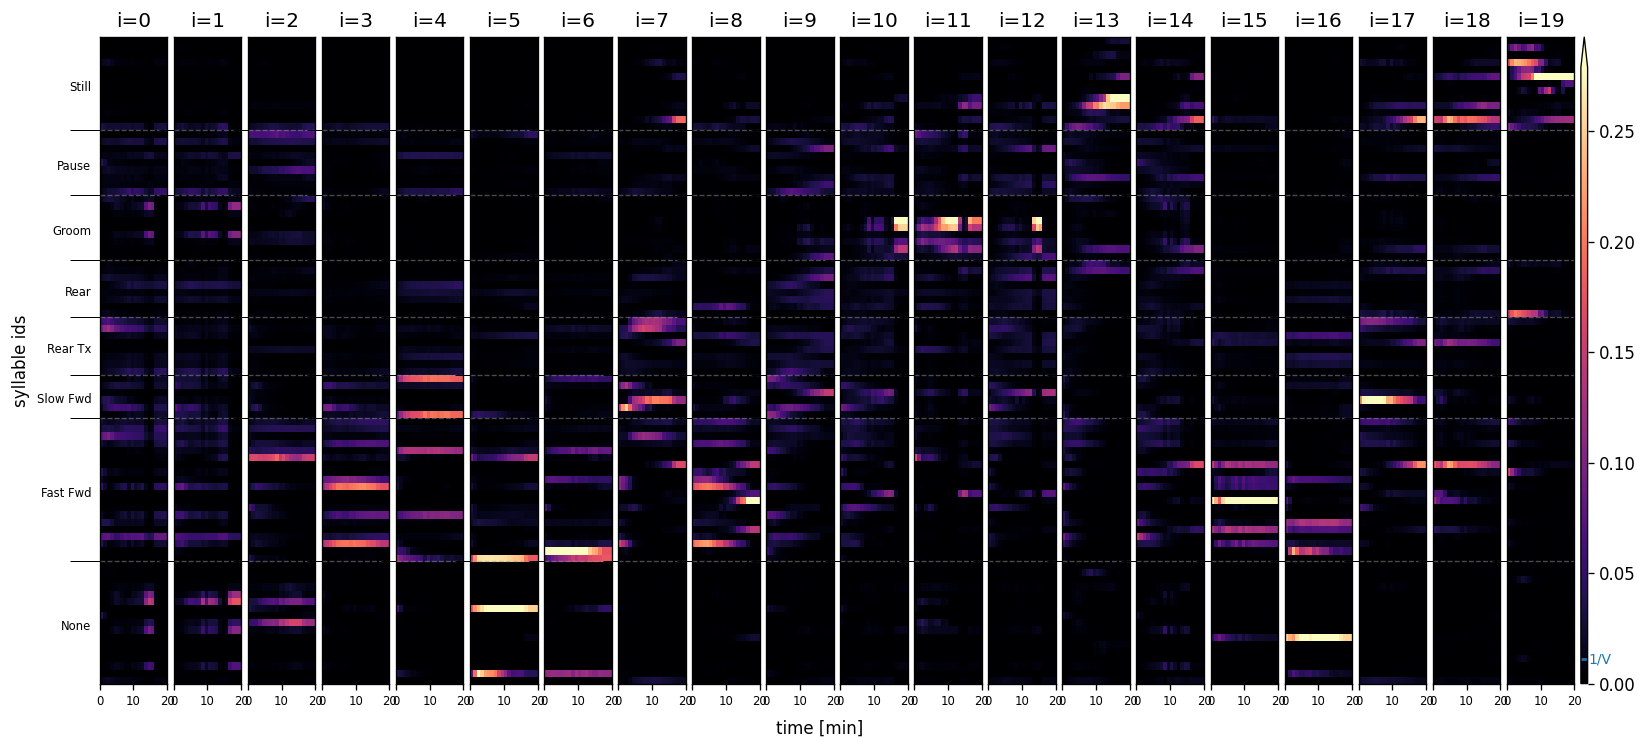

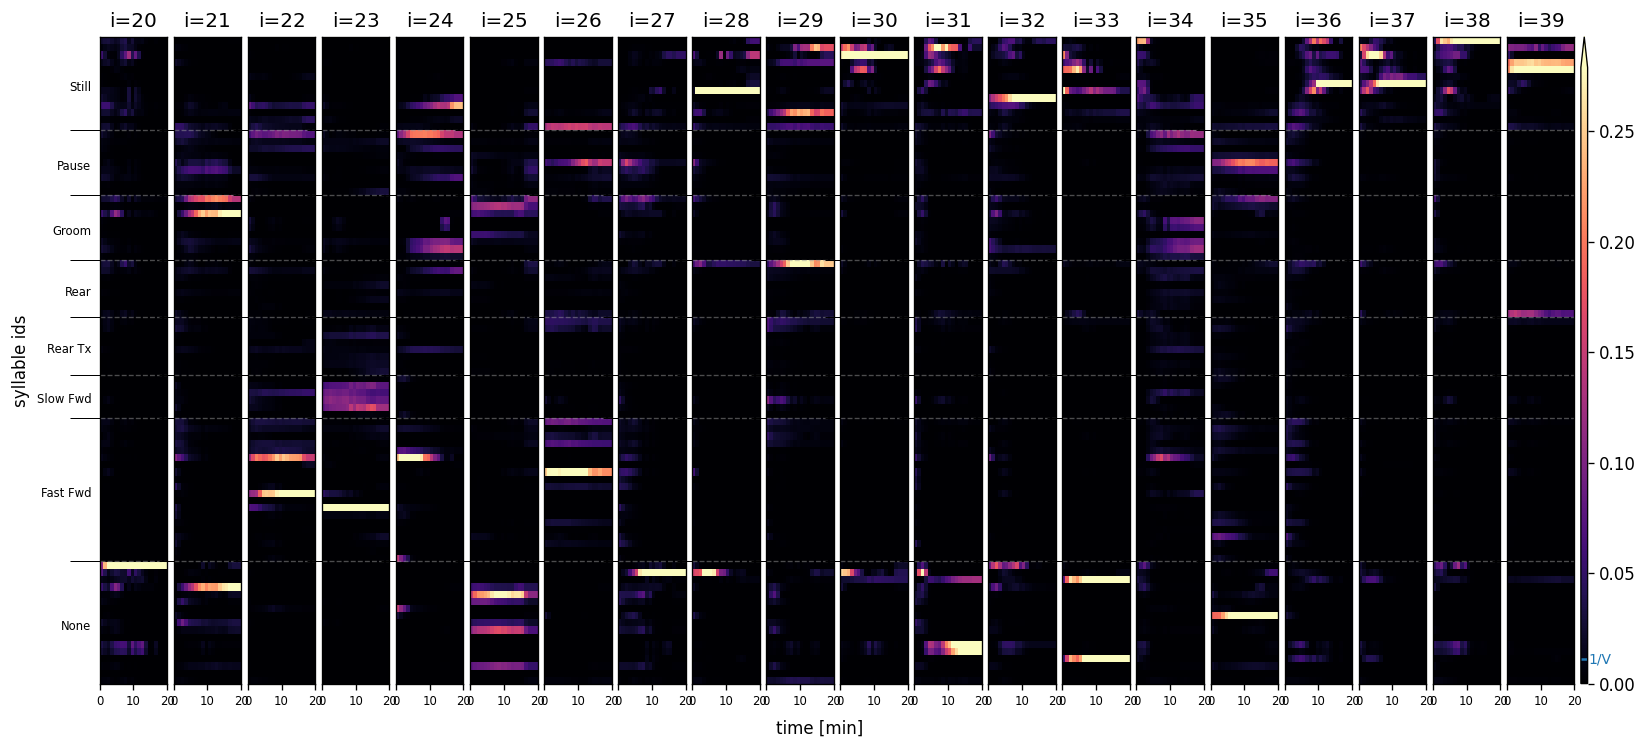

In [15]:
g, f1, f2, f3 = dtd_params_big

dynamic_topics = jnp.einsum("ijk,tj,kv->itv", g, f2, f3)
# vmax = dynamic_topics.max()
vmax = onp.percentile(dynamic_topics, 99.5)
k1, d2, d3 = dynamic_topics.shape

nrows = 2
for i_row in range(nrows):

    fig = plt.figure(figsize=(16,7), dpi=120)

    ncols = k1 // nrows
    axs = fig.subplots(
        ncols=ncols+1,  # add 1 for cax
        width_ratios=(1,)*ncols + (0.1,),
        gridspec_kw=dict(wspace=0.1),
    )
    axs, cax = axs[:-1], axs[-1]

    for ii, ax in enumerate(axs):
        i = ncols * i_row + ii
        im = ax.imshow(
            dynamic_topics[perm[i]].T,
            cmap='magma', clim=(0,vmax),
            interpolation='none', aspect='auto',
        )

        # Set within-session time ticks
        set_time_within_session_ticks(
            d2, frames_per_bin, frames_per_sec, tick_period=10, ax=ax
        )

        # Remove syllable axis ticks
        ax.set_yticks([])
        set_syllable_cluster_ticks(
            syllable_cluster_names,
            label=(True if ii==0 else False),
            ax=ax, axis='y',
        )

        ax.set_title(f"i={i}")

    cbar = plt.colorbar(im, cax=cax, extend='max')

    # Indicate "uniform" probability
    n_syllables = 90
    cbar.ax.axhline(1/n_syllables, c='C0')
    cbar.ax.text(
        1.05, 1/n_syllables, '1/V', transform=cbar.ax.get_yaxis_transform(),
        color='C0', va='center', fontsize='small',
    )

    plt.annotate(
        f"time [min]",
        (0.5, 0.05), xycoords=fig.transFigure, ha='center'
    )
    axs[0].set_ylabel('syllable ids')

    plt.show()


## Evaluate classifier performance

In [17]:
from sklearn.multiclass import OneVsRestClassifier

def train_linear_classifier(features, labels, C=100.0, n_fold=1, test_size=0.2, seed=0):
    """Traing a logistic regression classifier.
    
    Ported from "Load and Analyze Behavioral Fingerprints.ipynb" notebook in
        https://github.com/dattalab/moseq-drugs/blob/master/notebooks/Load%20and%20Analyze%20Behavioral%20Fingerprints.ipynb
    Modifications involve wrapping LogisticRegression with OneVsRestClassifier

    Parameters
        C (float): Inverse of regularization strength. Smaller values specify stronger regularization.
                   C=100 seems to work the best for across the board, but still worth varying.
    """

    splits = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed).split(features, labels)
    train_ind, test_ind = next(splits)

    # [multi_class="ovr"] Binarize labels to one-vs-rest
    # [class_weight="balanced"] Use the labels to automatically adjust weights inversely proportional to class frequencies
    # in the input data as `n_samples / (n_classes * np.bincount(y))`.
    model = OneVsRestClassifier(
        LogisticRegression(penalty='l2', C=C, solver='lbfgs', class_weight='balanced')
    )
    model.fit(features[train_ind], labels[train_ind])

    pred_labels = model.predict(features[test_ind])
    scores = model.predict_proba(features[test_ind])
    true_labels = labels[test_ind]

    return model, true_labels, pred_labels, scores

### Drug identity

In [102]:
label_level = 'drug_names' # also valid: drug_class, drug_doses
feature_types = list(features.keys())  # TO ADD: shuffled_moseq

y_str = metadata['session'][label_level]

# Get unique labels, in the order that they were seen ()
unique_labels, indices = onp.unique(metadata['session'][label_level], return_index=True)
unique_labels = [str(unique_labels[i]) for i in onp.argsort(indices)]

label_binarizer = LabelBinarizer().fit(unique_labels)
label_binarizer.classes_ = unique_labels  # Preserve order
y = label_binarizer.transform(y_str)  # shape (n_samples, n_labels)

<Axes: title={'center': 'StratifiedShuffleSplit'}, xlabel='Sample index', ylabel='CV iteration'>

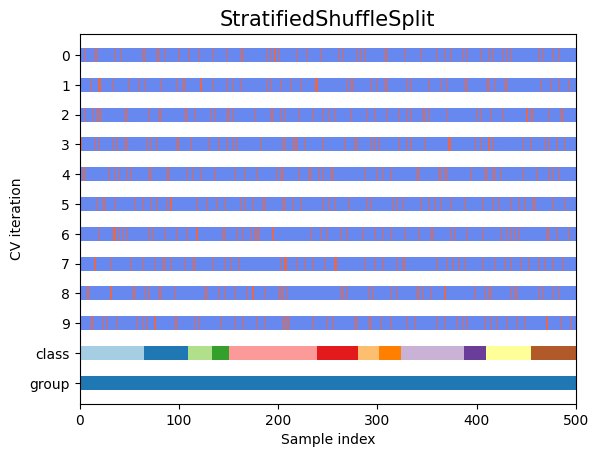

In [104]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, X, y, group, ax, max_splits_to_plot, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = onp.array([onp.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

        if ii + 1 == max_splits_to_plot:
            break

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(max_splits_to_plot)) + ["class", "group"]
    ax.set(
        yticks=onp.arange(max_splits_to_plot + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[max_splits_to_plot + 2.2, -0.2],
        xlim=[0, len(X)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

splitter = StratifiedShuffleSplit(n_splits=500, test_size=test_size, random_state=seed)
y_ = onp.nonzero(y)[1]  # Convert labels to indices for color mapper
plot_cv_indices(splitter, x, y_, None, plt.gca(), 10)  # Just show the first 10 splits

In [193]:
n_splits = 100
test_size = 0.1
seed = 0
C = 100

precisions = dict()
recalls = dict()
precisions_by_class = dict()
recalls_by_class = dict()
cms = dict()
f1s = dict()

for feature_type in feature_types:
    print(f'Working on {feature_type}')
    x = features[feature_type]

    splits = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=seed).split(x, y)

    these_f1s = []
    these_true_labels = []
    these_pred_labels = []
    these_scores = []
    these_cms = []
    precisions_by_class[feature_type] = dict()
    recalls_by_class[feature_type] = dict()

    for train_idxs, test_idxs in tqdm(splits, total=n_splits):
        model = OneVsRestClassifier(
            LogisticRegression(penalty='l2', C=C, solver='lbfgs', class_weight='balanced')
        )
        model.fit(x[train_idxs], y[train_idxs])

        true_labels = y[test_idxs]
        pred_labels = model.predict(x[test_idxs])
        scores = model.predict_proba(x[test_idxs])
        cm = confusion_matrix(
            label_binarizer.inverse_transform(true_labels), label_binarizer.inverse_transform(pred_labels)
        )
        f1 = f1_score(true_labels, pred_labels, average=None)

        these_true_labels.append(true_labels)
        these_pred_labels.append(pred_labels)
        these_scores.append(scores)
        these_cms.append(cm)
        these_f1s.append(f1)

    # shape (n_splits, ...)
    these_true_labels = onp.array(these_true_labels) # (n_splits, n_test, n_labels), one-hot encoding
    these_pred_labels = onp.array(these_pred_labels) # (n_splits, n_test, n_labels)
    these_scores = onp.array(these_scores)  # (n_splits, n_test, n_labels)
    these_cms = onp.array(these_cms)  # (n_splits, n_labels, n_labels)
    these_f1s = onp.array(these_f1s)  # (n_splits, n_labels)

    # Metrics
    # Per-class precision, recall metrics
    # Based on https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#in-multi-label-settings
    for i, lbl in enumerate(unique_labels):
        precisions_by_class[feature_type][lbl], recalls_by_class[feature_type][lbl], _ \
            = precision_recall_curve(all_true_labels[...,i].ravel(), all_scores[...,i].ravel())

    # Averages precision, recall metrics
    # A "micro-average": quantifying score on all classes jointly
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        these_true_labels.ravel(), these_scores.ravel()
    )  # (n_thresh,) where n_thresh = np.unique(scores)

    # Precision confusion matrices (normalied over total true instances)
    summed_cm = onp.asarray(these_cms.sum(axis=0), dtype=float)
    cms[feature_type] = summed_cm / summed_cm.sum(axis=0, keepdims=True) 

    f1s[feature_type] = these_f1s.mean(axis=0)  # shape (n_labels,)

Working on summary


  0%|          | 0/100 [00:00<?, ?it/s]

Working on lda


  0%|          | 0/100 [00:00<?, ?it/s]

Working on dtd_20_4_30


  0%|          | 0/100 [00:00<?, ?it/s]

Working on dtd_40_8_50


  0%|          | 0/100 [00:00<?, ?it/s]

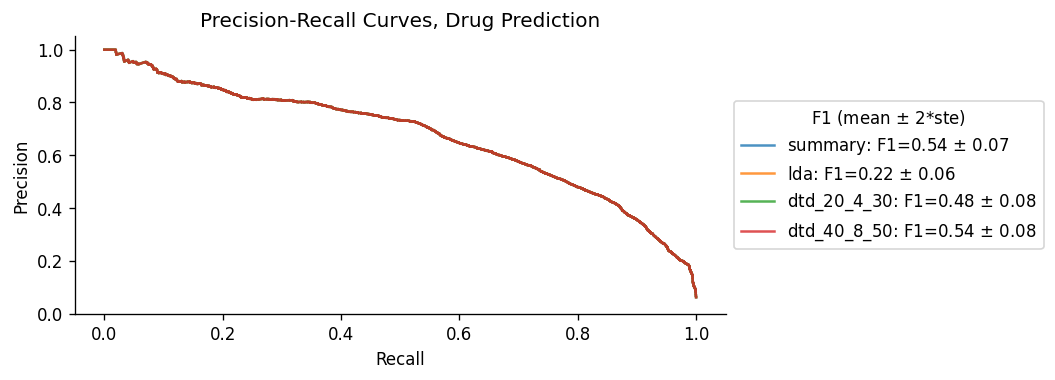

In [195]:
plt.figure(figsize=(7,3), dpi=120)
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {1.96*onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label, alpha=0.8)

ax.set_title('Precision-Recall Curves, Drug Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5], title=f"F1 (mean $\pm$ 2*ste)")
sns.despine()

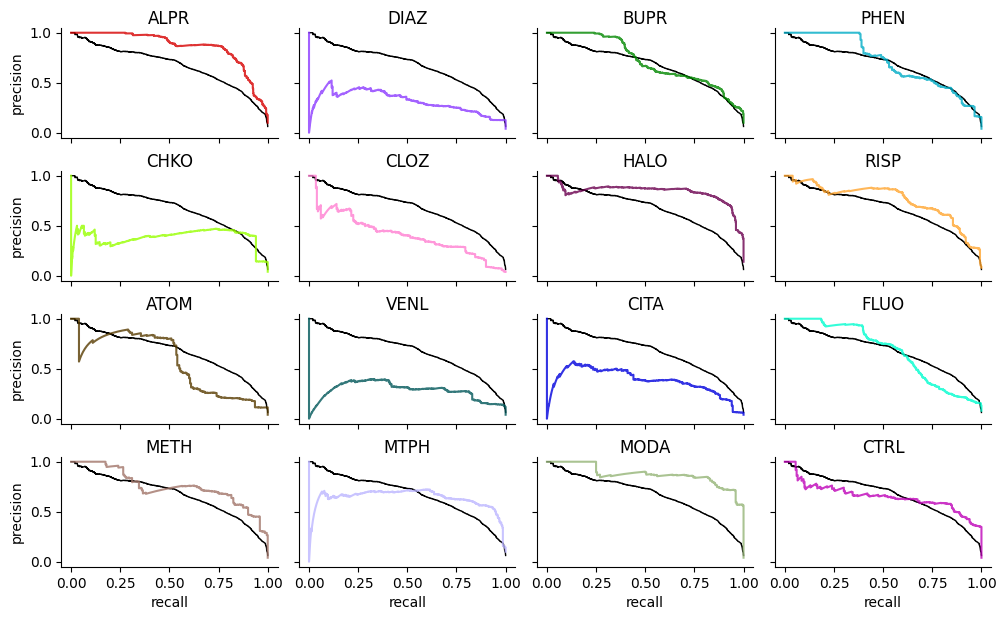

In [170]:

palette = sns.color_palette(cc.glasbey, n_colors=n_labels) 

nc = 4
fig, axs = plt.subplots(
    nrows=n_labels//nc, ncols=nc, figsize=(12,7),
    gridspec_kw=dict(wspace=0.1, hspace=0.3),
    sharex=True, sharey=True
)

for i, (ax, lbl) in enumerate(zip(axs.ravel(), unique_labels)):
    ax.plot(recall["micro"], precision["micro"], c='k', lw=1)
    ax.plot(recall[lbl], precision[lbl], c=palette[i], alpha=0.8)
    ax.set_title(lbl, y=0.96)

sns.despine()

for ax in axs[:,0]: ax.set_ylabel("precision")

for ax in axs[-1,:]: ax.set_xlabel("recall")


Text(0.5, 1.0, 'Precision confusion matrix')

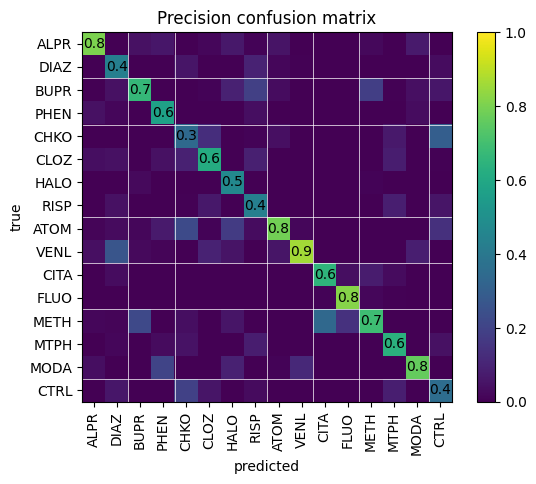

In [91]:
# For recall, tp / (tp+fn): normalize by predicted labels, axis=1. Priortizes not missing possible
# For precision, tp / (tp+fp): normalize by true labels, axis=0. Prioritizes accuracy
total_cm = onp.asarray(all_cms.sum(axis=0), dtype=float)  # shape (n_labels, n_labels)
total_cm /= total_cm.sum(axis=0, keepdims=True)  # normalize by number of true labels

drug_class_sep = onp.array([2,4,8,10,12,15])  # Manual

im = plt.imshow(total_cm, clim=(0,1))
plt.colorbar(im)

# Draw lines seperating drug classes
plt.vlines(drug_class_sep-0.5, -0.5, n_labels-0.5, color='white', lw=0.5)
plt.hlines(drug_class_sep-0.5, -0.5, n_labels-0.5, color='white', lw=0.5)

# label diagonal
for i in range(n_labels):
    plt.text(i,i, f"{total_cm[i,i]:.1f}", ha='center', va='center')

plt.xlabel("predicted")
plt.xticks(range(n_labels), unique_labels, rotation=90)
plt.ylabel("true")
plt.yticks(range(n_labels), unique_labels);

plt.title("Precision confusion matrix")

In [32]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = features[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for i_seed in trange(n_samples):
        # Using C=1 (strong reg) led to strong decline in F1 score
        # Using C=1e3 (lower reg) led to lbfgs failing to converge
        model, true_labels, pred_labels, scores = train_linear_classifier(x, y, test_size=0.10, seed=i_seed)  
        all_true_labels.append(model.label_binarizer_.transform(true_labels).toarray())  # For use with OVR
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        onp.array(all_true_labels).ravel(), onp.array(all_scores).ravel()
    )
    # f1s[feature_type] = onp.mean(f1s[feature_type], axis=0) # average over seeds

    break

Working on summary


  0%|          | 0/500 [00:00<?, ?it/s]

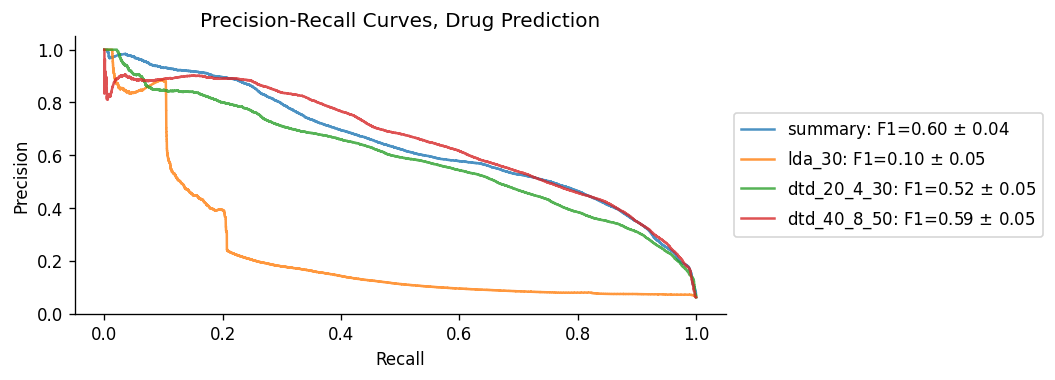

In [90]:
plt.figure(figsize=(7,3), dpi=120)
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label, alpha=0.8)

ax.set_title('Precision-Recall Curves, Drug Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

Numerically, the simple summary statistics still have the highest F1 score, although its score and the "bigger" dtd are comparable and not significiantly different (plus/minus is single standard error (?)). Promisingly, the "bigger" dtd model (`dtd_40_8_50`) is performs slight better in the middle recall values range. This model performs better than the "parsimonious" dtd (`dtd_20_4_30`), as might be expected.

I am quite surprised that the LDA performed so poorly. This LDA _is_ different from my previous implementation because it is fitting the session summary statistics (ie. `summary`). Previously, I had matricized the data into a matrix of shape `(n_sessions, n_timebins x n_syllables)` prior to fitting, and the resulting performance was comparable. We'd likely want to run cross-validation on the LDA model to find the optimal number of topics; here, we simply picked the number of topics that we used in DTD.

One thing we need to dig into is exactly why there are big drops in the "bigger" dtd model's performance on the left hand side. This [StackExchange post](https://stats.stackexchange.com/questions/624817/sudden-drop-to-zero-for-precision-recall-curve) suggests some further analyses and inspections -- the drop is likely due to some edge cases. To be followed-up on ... for now, let's examine performance on drug-dose and drug class predictions.

### Drug-dose

In [108]:
feature_types = list(features.keys())  # TO ADD: shuffled_moseq

y_str = drug_dose_labels
unique_labels = onp.unique(y_str)
label_binarizer = LabelBinarizer().fit(unique_labels)
y = label_binarizer.transform(y_str)

n_samples = 500 # for bootstrap measurements

In [111]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = features[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for i_seed in trange(n_samples):
        # Using C=1 (strong reg) led to strong decline in F1 score
        # Using C=1e3 (lower reg) led to lbfgs failing to converge
        model, true_labels, pred_labels, scores = train_linear_classifier(x, y, test_size=0.10, seed=i_seed)  
        all_true_labels.append(model.label_binarizer_.transform(true_labels).toarray())  # For use with OVR
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        onp.array(all_true_labels).ravel(), onp.array(all_scores).ravel()
    )
    f1s[feature_type] = onp.mean(f1s[feature_type], axis=0) # average over seeds

Working on summary


  0%|          | 0/500 [00:00<?, ?it/s]

Working on lda_30


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_20_4_30


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_40_8_50


  0%|          | 0/500 [00:00<?, ?it/s]

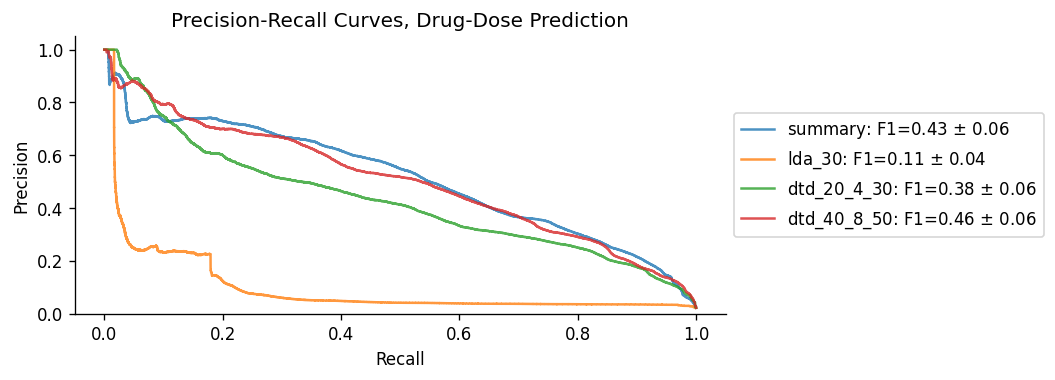

In [112]:
plt.figure(figsize=(7,3), dpi=120)
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label, alpha=0.8)

ax.set_title('Precision-Recall Curves, Drug-Dose Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()

Label binarization error -- I've encountered this before, look at old notebook to fix it.

### Drug class

In [105]:
label_level = 'drug_class' # also valid: drug_class, drug_doses
feature_types = list(features.keys())  # TO ADD: shuffled_moseq

y = metadata['session'][label_level]
unique_labels = onp.unique(y)
n_labels = len(unique_labels)
label_binarizer = LabelBinarizer().fit(onp.arange(n_labels))

n_samples = 500 # for bootstrap measurements

In [106]:
precisions = OrderedDict(())
recalls = OrderedDict(())
f1s = OrderedDict(())

for feature_type in feature_types:
    print(f'Working on {feature_type}')

    x = features[feature_type]
        
    f1s[feature_type] = []
    all_true_labels = []
    all_scores = []
    
    for i_seed in trange(n_samples):
        # Using C=1 (strong reg) led to strong decline in F1 score
        # Using C=1e3 (lower reg) led to lbfgs failing to converge
        model, true_labels, pred_labels, scores = train_linear_classifier(x, y, test_size=0.10, seed=i_seed)  
        all_true_labels.append(model.label_binarizer_.transform(true_labels).toarray())  # For use with OVR
        all_scores.append(scores)
        
        per_label_f1 = f1_score(true_labels, pred_labels, average=None)
        f1s[feature_type].append(per_label_f1)
  
    precisions[feature_type], recalls[feature_type], _ = precision_recall_curve(
        onp.array(all_true_labels).ravel(), onp.array(all_scores).ravel()
    )
    f1s[feature_type] = onp.mean(f1s[feature_type], axis=0) # average over seeds

Working on summary


  0%|          | 0/500 [00:00<?, ?it/s]

Working on lda_30


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_20_4_30


  0%|          | 0/500 [00:00<?, ?it/s]

Working on dtd_40_8_50


  0%|          | 0/500 [00:00<?, ?it/s]

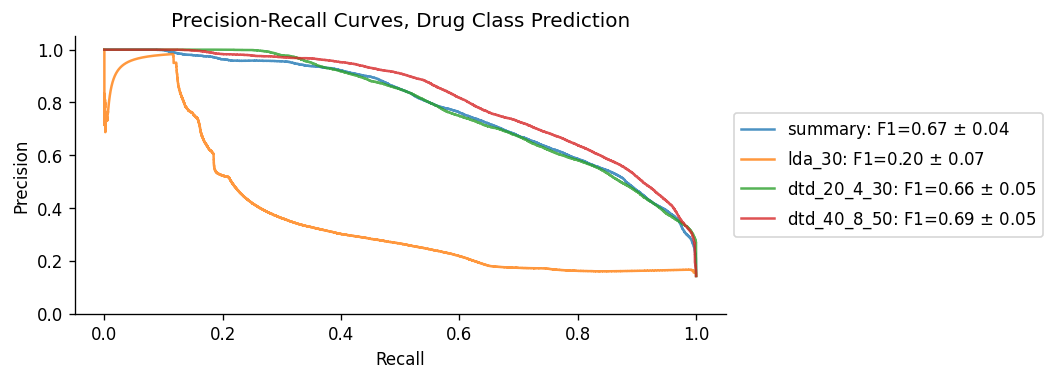

In [107]:
plt.figure(figsize=(7,3), dpi=120)
ax = plt.gca()

for feature_type in feature_types:
    label = rf"{feature_type}: F1={onp.mean(f1s[feature_type]):.2f} $\pm$ {onp.std(f1s[feature_type])/onp.sqrt(n_labels):.2f}"
    ax.plot(recalls[feature_type], precisions[feature_type], label=label, alpha=0.8)

ax.set_title('Precision-Recall Curves, Drug Class Prediction')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim(0, 1.05)
ax.legend(loc='center left', bbox_to_anchor=[1,0.5])
sns.despine()